## Imports

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from keras.models import Model
import boto3
from time import time
import os
import io
from tqdm import tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
import math
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load Model

In [2]:
model = tf.keras.models.load_model('/home/drevital/cs_video_processor/models/suzuyo')

## General Settings

In [3]:
IMG_HEIGHT, IMG_WIDTH = 200, 200
BATCH_SIZE = 32
NUM_RAND_IMAGES = 10
batch_size = min(BATCH_SIZE, NUM_RAND_IMAGES*2)
obstacle_pairs = []
no_obstacle_pairs = []

## Utility functions for S3 Image Data Generator

In [4]:
def get_image(imname):
    client = boto3.client('s3')
    bucket = 'obstacles-classification'
    key = imname
    outfile = io.BytesIO()
    client.download_fileobj(bucket, key, outfile)
    outfile.seek(0)
    im = plt.imread(outfile, format='jpg')
    return im

def preprocess_image(im):
    w = im.shape[1]
    im1 = im[:,:w//2]
    im2 = im[:,w//2:]
    sub = cv2.subtract(im1, im2)
    sub = sub.reshape(sub.shape[0], sub.shape[1], 1)
    arr = keras.preprocessing.image.smart_resize(sub,
                                                 (IMG_HEIGHT, IMG_WIDTH),
                                                 interpolation='bilinear')
    arr /= 255.0
    return arr

## Define S3 Image Generator

In [5]:
def s3_image_generator(obstacle_image_names, no_obstacle_image_names, batch_size, eval=False):
    s3 = boto3.resource('s3')
    inputs = []
    outputs = [1]*NUM_RAND_IMAGES + [0]*NUM_RAND_IMAGES
    num_images = NUM_RAND_IMAGES*2
    
    for image_name in tqdm(obstacle_image_names):
        im = get_image(image_name)
        if eval:
            obstacle_pairs.append(im)
        im = preprocess_image(im)
        inputs.append(im)
        
    for image_name in tqdm(no_obstacle_image_names):
        im = get_image(image_name)
        if eval:
            no_obstacle_pairs.append(im)
        im = preprocess_image(im)
        inputs.append(im)

    for i in range(0, num_images, batch_size):
        x = np.array(inputs[i:i+batch_size])
        y = np.array(outputs[i:i+batch_size])
        yield(x, y)

## Function to read dataset file names from s3

In [6]:
def get_dataset_image_names(dataset, num_images):
    client = boto3.client('s3')
    bucket = 'obstacles-classification'
    image_names = []

    paginator = client.get_paginator('list_objects')
    page_iterator = paginator.paginate(Bucket=bucket, Prefix=dataset)

    for page in page_iterator:
        for image_name in page['Contents']:
            if image_name['Key'].split('.')[-1] == 'jpg':
                image_names.append(image_name['Key'])
                
    image_names = np.array(image_names)
    np.random.shuffle(image_names)

    return image_names[:num_images]

## Function to display Confusion Matrix

In [7]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No Obstacles Detected (True Negatives): ', cm[0][0])
  print('No Obstacles Incorrectly Detected (False Positives): ', cm[0][1])
  print('Obstacles Missed (False Negatives): ', cm[1][0])
  print('Obstacles Detected (True Positives): ', cm[1][1])
  print('Total Obstacles: ', np.sum(cm[1]))

## Fetch list of files in Evaluation Dataset to serve the S3 file-generator

In [8]:
dataset = 'suzuyo/eval_pairs/obstacle'
obstacle_image_names = get_dataset_image_names(dataset, NUM_RAND_IMAGES)
dataset = 'suzuyo/eval_pairs/no_obstacle'
no_obstacle_image_names = get_dataset_image_names(dataset, NUM_RAND_IMAGES)
num_obstacles = len(obstacle_image_names)
num_no_obstacles = len(no_obstacle_image_names)
num_images = num_obstacles + num_no_obstacles

## Evaluate model and print metrics

In [9]:
metrics = model.evaluate_generator(s3_image_generator(obstacle_image_names,
                                                      no_obstacle_image_names,
                                                      batch_size,
                                                      eval=True),
                                   verbose=1)

for name, value in zip(model.metrics_names, metrics):
  print(name, ': ', value)
print()

/home/drevital/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


1/1 [==============================] - 1s 786ms/step - loss: 0.4847 - auc: 1.0000 - recall: 0.6000 - specifity: 1.0000
loss :  0.48466959595680237
auc :  0.9999999403953552
recall :  0.6000000238418579
specifity :  1.0



## Predict with the model and print prediction charts

/home/drevital/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


1/1 [==============================] - 0s 273ms/step
No Obstacles Detected (True Negatives):  10
No Obstacles Incorrectly Detected (False Positives):  0
Obstacles Missed (False Negatives):  4
Obstacles Detected (True Positives):  6
Total Obstacles:  10


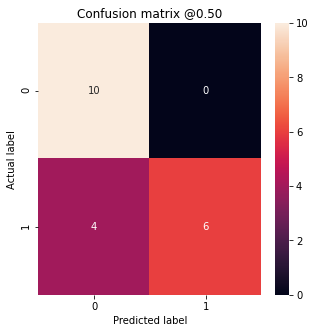

In [10]:
labels = np.array([1]*(NUM_RAND_IMAGES) + [0]*(NUM_RAND_IMAGES))
num_prediction_batches = math.ceil((NUM_RAND_IMAGES*2)/batch_size)

predictions = model.predict_generator(s3_image_generator(obstacle_image_names, 
                                                         no_obstacle_image_names, 
                                                         batch_size),
                                      num_prediction_batches,
                                      verbose=1)

plot_cm(labels, predictions) # Default: threshold = 0.5

## Display False Negatives

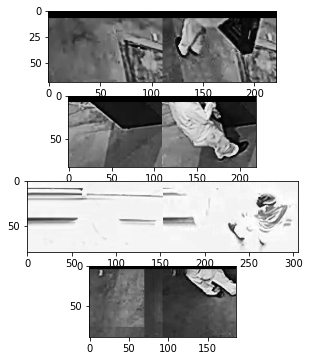

In [11]:
false_negatives = [im for i, im in enumerate(obstacle_pairs) if predictions[i] <= 0.5]

if false_negatives:
    num_images = len(false_negatives)
    _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

    for i, im in enumerate(false_negatives):
        axarr[i].imshow(im, cmap='gray', vmin=0, vmax=255)

## Display False Positives

In [12]:
false_positives = [im for i, im in enumerate(no_obstacle_pairs) if predictions[i+NUM_RAND_IMAGES] > 0.5]

if false_positives:
    num_images = len(false_positives)
    _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

    for i, im in enumerate(false_positives):
        axarr[i].imshow(im, cmap='gray', vmin=0, vmax=255)

## Find Optimal Threshold

In [13]:
true_values = [1]*NUM_RAND_IMAGES + [0]*NUM_RAND_IMAGES
fpr, tpr, thresholds = roc_curve(true_values, predictions)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
optimal_threshold = thresholds[ix]
print(f'Optimal Threshold: {optimal_threshold}')

Optimal Threshold: 0.21185162663459778


## Use Optimal Threshold

No Obstacles Detected (True Negatives):  10
No Obstacles Incorrectly Detected (False Positives):  0
Obstacles Missed (False Negatives):  1
Obstacles Detected (True Positives):  9
Total Obstacles:  10


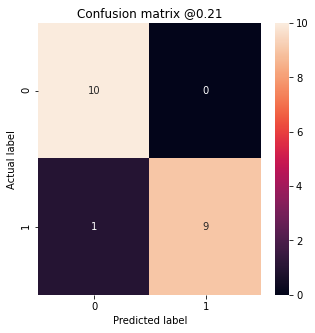

In [14]:
plot_cm(labels, predictions, p=optimal_threshold) 